# NLP on disaster tweets - Kaggle Competition

## Imports organized in one cell

In [231]:
import numpy as np
import pandas as pd
import nltk
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_validate, LeaveOneOut, KFold, ShuffleSplit
from sklearn.linear_model import LogisticRegression, PassiveAggressiveRegressor, LinearRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from math import floor

## Loading data

In [232]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

## Data structure

In [233]:
print('Train has {0} rows and {1} columns'.format(train.shape[0], train.shape[1]))
print('Test has {0} rows and {1} columns'.format(test.shape[0], test.shape[1]))

Train has 7613 rows and 5 columns
Test has 3263 rows and 4 columns


In [234]:
positive_prcnt = train['target'].value_counts()[0]/train['target'].count()*100
negative_prcnt = train['target'].value_counts()[1]/train['target'].count()*100
print('Percentage of positive cases: {0}% '.format(round(positive_prcnt, 2)))
print('Percentage of negative cases: {0}% '.format(round(negative_prcnt, 2)))

Percentage of positive cases: 57.03% 
Percentage of negative cases: 42.97% 


## Loading english stopwords

In [235]:
stopwords = set(nltk.corpus.stopwords.words('english'))

## Adding punctuation on stopwords

In [236]:
for punct in punctuation:
    stopwords.add(punct)

## Creating TD-IDF object

In [237]:
SEED = 321321
np.random.seed(SEED)

In [238]:

vect = TfidfVectorizer(lowercase=True, max_features=100, ngram_range=(1,2))
raw_tfidf = vect.fit_transform(train.text).toarray()
# treino, teste, classe_treino, classe_teste = train_test_split(tfidf_bruto, train.target)
classes = train.target

In [239]:
def validador_de_modelos(model, train, test, class_train, class_test, cross_validation=0.2):
    model.fit(train, class_train)
    
    predict = model.predict(test)
    
    print("O modelo passado teve acuracia de {0}".format(model.score(test,class_test)))

In [240]:
def cross_validation(model, x, y, validation_splitter):
    print(model)
    print('\n')
    print(validation_splitter)
    cv = cross_validate(model, x, y, cv=validation_splitter)
    st_deviation = cv['test_score'].std()
    mean  = cv['test_score'].mean()
    conf_interval = [(mean-2 * st_deviation)*100, (mean+2 * st_deviation)*100]

    print('\n################################\n')
    print('Mean score: {0}'.format(np.mean(cv['test_score'])))
    print('Median score: {0}'.format(np.median(cv['test_score'])))
    print('Min score: {0}'.format(np.amin(cv['test_score'])))
    print('Max score: {0}'.format(np.amax(cv['test_score'])))
    print('\n################################\n')
    print('Confident interval: [{0}% , {1}%]'.format(round(conf_interval[0],2), round(conf_interval[1], 2)))
    print('\n')

## Instantiating models

In [241]:
rc = RidgeClassifier()
lor = LogisticRegression()
par = PassiveAggressiveRegressor()
dtr = DecisionTreeRegressor()
dtc = DecisionTreeClassifier(criterion = 'entropy')
gnb = GaussianNB()
classifiers_list= [rc, lor, par, dtr, dtc, gnb]

In [242]:
kf = KFold(100, True)
ss = ShuffleSplit(n_splits=10)

split_list = [kf, ss]

## Testing models with cross_validate

In [243]:
# for classifier in classifiers_list:
#     for splitter in split_list:
#         cross_validation(classifier, raw_tfidf, classes, splitter)
# Commenting this routine due to slow processing

# chosen methods so far: RidgeClassifier with KFold splitter - 60% to 80% of confident interval
cross_validation(rc, raw_tfidf, classes, kf)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)


KFold(n_splits=100, random_state=None, shuffle=True)

################################

Mean score: 0.7115516062884484
Median score: 0.7105263157894737
Min score: 0.5921052631578947
Max score: 0.868421052631579

################################

Confident interval: [61.04% , 81.27%]




# Testing model fit through manual tratative on text

## Creating token column

In [244]:
train['token'] = train.text.apply(nltk.tokenize.word_tokenize)
train.head()

,id,keyword,location,text,target,token
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[Our, Deeds, are, the, Reason, of, this, #, ea..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[Forest, fire, near, La, Ronge, Sask, ., Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[All, residents, asked, to, 'shelter, in, plac..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #, wildfires, evacua..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[Just, got, sent, this, photo, from, Ruby, #, ..."


## Removing stopwords from token column

In [245]:
def remove_stopwords(text):
    token_without_stopwords = [w for w in text if w not in stopwords]
    return token_without_stopwords

train['token_without_stopwords'] = train.token.apply(remove_stopwords)

## Stemming words

In [246]:
def stemmer(text):
    stemmer = nltk.stem.PorterStemmer()
    stemmed_text = [stemmer.stem(w) for w in text]
    return stemmed_text

train['stemmed_tokens'] = train.token_without_stopwords.apply(stemmer)

## Generating Frequency Distribution of the last tratative

In [247]:
word_list = list()
for list_of_words in train['stemmed_tokens']:
    word_list.append(' '.join(map(str, list_of_words)))

train['string_stemmed_tokens'] = word_list

In [248]:
cv = CountVectorizer(max_features=1000)
X = cv.fit_transform([w.lower() for w in train['string_stemmed_tokens']]).toarray()
y = train.target.values

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [250]:
score_list = list()
for train_index, test_index in kf.split(X, y):
    rc = RidgeClassifier()
    cv_X_train, cv_y_train, cv_X_test, cv_y_test = X[train_index], y[train_index], X[test_index], y[test_index]
    rc.fit(cv_X_train, cv_y_train)
    predict = rc.predict(cv_X_test)
    score_list.append(accuracy_score(predict, cv_y_test))
score_array = np.array(score_list)



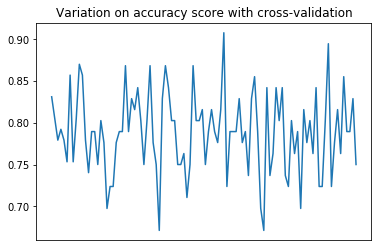

In [251]:
fig = plt.figure()

plt.title("Variation on accuracy score with cross-validation")
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.plot(score_array)

## Ordered plot

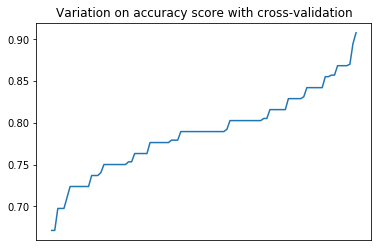

In [252]:
fig = plt.figure()

plt.title("Variation on accuracy score with cross-validation")
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.plot(np.sort(score_array))

In [253]:
st_deviation = score_array.std()
mean  = score_array.mean()
median  = np.median(score_array)
conf_interval = [(mean-2 * st_deviation)*100, (mean+2 * st_deviation)*100]

print('\n################################\n')
print('Mean score: {0}'.format(mean))
print('Median score: {0}'.format(median))
print('Min score: {0}'.format(score_array.min()))
print('Max score: {0}'.format(score_array.max()))
print('\n################################\n')
print('Confident interval: [{0}% , {1}%]'.format(round(conf_interval[0],2), round(conf_interval[1], 2)))
print('\n')


################################

Mean score: 0.7882365003417634
Median score: 0.7894736842105263
Min score: 0.6710526315789473
Max score: 0.9078947368421053

################################

Confident interval: [69.28% , 88.37%]




## Manual manipulation came out slightly better than tfidf model
### Submit will be generated with the hand-made data, with new seed

In [254]:
rc = RidgeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42225420)
rc.fit(X_train, y_train)
pr = rc.predict(X_test)
print("Final model accuracy: {:.2%}".format(accuracy_score(pr, y_test)))

Final model accuracy: 79.45%


## Generating submit

In [255]:
test['token'] = test.text.apply(nltk.tokenize.word_tokenize)
test['token_without_stopwords'] = test.token.apply(remove_stopwords)
test['stemmed_tokens'] = test.token_without_stopwords.apply(stemmer)

word_list = list()
for list_of_words in test['stemmed_tokens']:
    word_list.append(' '.join(map(str, list_of_words)))

test['string_stemmed_tokens'] = word_list
test_x = cv.transform([w.lower() for w in test['string_stemmed_tokens']]).toarray()

In [256]:
test['target'] = rc.predict(test_x)

In [257]:
submit = test[['id', 'target']]
submit.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
